In [1]:
# standard tools in Python for economists
import numpy as np 
from   numpy import linspace, logspace, log, exp, sqrt, bmat, zeros, ones, round
from numpy.linalg import inv, norm, eig
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.interpolate import interp1d
from numba import jit, njit, guvectorize  # vectorizes loops to improve performance
from numpy.matlib import repmat
# pip install quantecon  ### run this the first time you install quantecon
import quantecon as qe
from quantecon import MarkovChain

# Problem 2

In [2]:
β = .96
r = .03
γ = 1
δ = 0.05
α = 0.3
u = lambda c, γ: c**(1-γ)/(1-γ) if γ!=1 else log(c) #utility function
u1 = lambda c, γ: c**(-γ) #u'
u1inv = lambda u1, γ: u1**(-1/γ) #u' inverse

e_backward = 1e-10 # backward iteration tolerance
imax_backward = 1e5 # max iterations for backward iteration

# e_forward = 1e-10 # forward iteration tolerance
# imax_forward = 1e5 # max iterations for forward iteration

# baseline income grid and transition
yL = 1
yH = 2
ns = 2
s_grid = np.array([yL, yH])
Π = np.array([[.95, .05], [.1, .9]]) # transition matrix

# asset grid
amin = 0
amax = 100
na = 1000

# Interest rate grid
nR = 10
R_grid = np.linspace(1,1/β, num=nR)

In [3]:
# Here are a few specifications you can play with

# baseline parameters
param_base = {'δ': δ, 'α': α, 'r': r, 'β': β, 'γ': γ, 'yL': yL, 'yH':yH, 'θ': 0, 'x': 0, 'amin': 0}

In [4]:
# Wages as fxn of R
def w_R(R, param=param_base):
    α = param['α']
    δ = param['δ']
    w = (1-α)*(α**(α/(1-α)))*((R-1+δ)**(-α/(1-α)))
    return w

In [5]:
def prepare(yL=yL, yH=yH, amin=amin, amax=amax, na=na, θ=0, x=0):
    
    s_grid = np.array([yL, yH]) # set up income grid (1x2)
    
    c = abs(amin) + 1
    a_grid = np.exp(np.linspace(np.log(c+amin), np.log(c+amax), num = na)) - c # exponential grid
    ma_grid, ms_grid = np.meshgrid(a_grid, s_grid) # create grid of assets and income values
    
    # prepare transition matrix
    Π = np.array([[.95-θ, .05+θ], [.1+θ, .9-θ]])
    
    # find stationary earning distribution, useful only in PS4
    s_dist = ones(ns)/ns
    for i in range(1000):
        s_dist = Π.T@s_dist # stationary distribution

    return ma_grid, ms_grid, Π, s_dist

# baseline
ma_grid, ms_grid, Π, s_dist = prepare()
coh = (1+r)*ma_grid + ms_grid # cash on hand

In [6]:
# ---------------------------------------------------
# 1-step backward iteration
def backward1(Va_future, r=r, β=β, γ=γ, ma_grid=ma_grid, coh=coh, Π=Π, report='N'):
    
    Va_future[Va_future < 1e-5] = 1e-5
    cnext = u1inv(β * Π @ Va_future, γ) # cnext is a function of s and a'
        # backing out c using equated marginal utilities across periods
        
    a_policy = ones([ns,na]) #initialize asset policy matrix (2x1000)
    for s in range(ns):  #iterate over states
        x = coh[s,:] # vector showing cash on hand matrix for given income at all possible asset values (1x1000)
        xp = cnext + ma_grid # given that you ended up with assets ma_grid and consumed cnext, you must have started
            # with assets in xp matrix
        xp = xp[s,:] # take the vector from that matrix for your state
        fp = ma_grid[s,:] 
        # np.interp: x to xp is the output to fp
        a_policy[s,:] = np.interp(x, xp, fp)

        
    # set a and c to respect the borrowing limit
    a_policy[a_policy < ma_grid[0,0]] = ma_grid[0,0] # set any elements below lowest asset value to lowest value
    c_policy = coh - a_policy # get consumption from cash on hand and savings decisions
    c_policy[c_policy < 1e-5] = 1e-5 # bring all consumption up to min value
    a_policy = coh - c_policy # recalculate assets based on bounded consumption
    Va = (1+r)*u1(c_policy, γ) # get next value fxn derivative value matrix using new consumption policy
    return Va, a_policy, c_policy

# ---------------------------------------------------
# backward iteration to steady state
def backward(param=param_base, w='exog', report='N', criterium='Va',\
             error=e_backward, imax=imax_backward): 
    r = param['r']
    β = param['β']
    γ = param['γ']
    
    if w=='exog': #if wage =1 set exogenously
        yL = param['yL']
        yH = param['yH']
    else: #if wage is set endogenously
        w = w_R(1+r, param=param) # get wage as fxn of r
        yL = w*param['yL']
        yH = w*param['yH']
        
    # make grids
    ma_grid, ms_grid, Π, s_dist = prepare(yL=yL, yH=yH, amin=param['amin'], θ=param['θ'], x=param['x']) #set up grids using parameters
    coh = (1+r)*ma_grid + ms_grid # cash on hand, using return on assets carried into current period plus income in current period
    param.update({'ma_grid': ma_grid, 'ms_grid': ms_grid, 'coh': coh, 
                  'a_grid': ma_grid[0,:], 's_grid': ms_grid[:,0], 'Π': Π, 's_dist': s_dist}) 
        #update all of the parameters based on new grid values
    
    # initial guess to start the iteration. consume 5% of coh
    c_policy0 = .05*coh
    c_policy0[c_policy0 < 1e-5] = 1e-5 # fix any values below min
    Va0 = (1+r)*u1(c_policy0, γ) # get new value function derivative using guessed consumption policy

    if report == 'Y':
        print('-----\nBackward iteration starts.')
    
    i = 0
    e = error+1
    if i == 0:
        Va_old = Va0
        Va_old[Va_old < 1e-5] = 1e-5
        c_policy_old = u1inv(Va_old/(1+r), γ) # get old consumption guess by inverting value fxn derivative
    
    while e > error and i < imax: #while outside of acceptable range and not at max iterations
        Va, a_policy, c_policy = backward1(Va_old, r=r, β=β, γ=γ, ma_grid=ma_grid, coh=coh, Π=Π, report=report)
            #iterate backwards one step
        # convergence criterium block
        if criterium == 'c': # error based on consumption policy
            e = np.max(np.abs(c_policy-c_policy_old))
        elif criterium == 'Va': # error based on Va
            e = np.max(np.abs(Va-Va_old))
        else:
            raise ValueError("criterium has to be 'c' or 'Va'")
        
        #c_policy_old = c_policy # use new c policy as old in next iteration
        Va_old = Va # use new value function derivative as old in next iteration
        i += 1
        if i % 500 == 0 and report == 'Y':
            print('current iteration:', i)
            print('current error:', e)
        
    if i == imax:
        print('Warning! -- used max backward iteration:', imax)
    if report == 'Y':
        print('# of iterations:', i)
        print('error:', e)
        print('Backward iteration ends.\n-----')
        
    return Va, a_policy, c_policy, param 
        # return value derivative, final policies, final parameters one policies/value fxn deriv have converged

In [7]:
Va, a_policy, c_policy, param = backward()

In [8]:
# Defining a function that maps assets a to a 
# grid with probabilities of transitioning to different asset states

# a argument is non-grid a' (i.e., a value output by a policy fxn) 
# that we want to convert into transition probabilities for up to 2 states on the grid
def a_prob(a, ma_grid):
    a_prob_grid = zeros([ns,na])
    for s in range(ns):
        a1_idx = np.argmin(np.abs(np.array(ma_grid[s,:])-a)) # get a1 on grid closest to a
        a1 = ma_grid[s,a1_idx]
        if a < ma_grid[s,a1_idx]: # if a < a1
            a2_idx = a1_idx - 1 # a2 is the closest lower gridpoint
        elif a > ma_grid[s, a1_idx]: # if a > a1
            a2_idx = a1_idx + 1 # a2 is the closest higher gridpoint
        else:
            a2_idx = a1_idx
            a_prob_grid[s, a1_idx] = 1
            continue # move on to next s
        a2 = ma_grid[s,a2_idx]
        # At this point we know closest a1, a2 to a
        # probability of transitioning into a1 = p
        p = (a2 - a)/(a2 - a1)
        a_prob_grid[s, a1_idx] = p
        a_prob_grid[s, a2_idx] = 1-p
    return a_prob_grid

# returns ns x na matrix where e/ cell is the prob of 
# ending up in that asset state given that you started in a

In [9]:
# Define function that generates transition matrix T between (y, a) states
def make_T(a_policy, Π=Π, ma_grid=ma_grid):
    # Π is ns x ns transition matrix for income states
    # a_policy is ns x na matrix, gives a' for starting state (y, a)
    # a_policy is R-specific!
    
    n_states = ma_grid.shape[0] * ma_grid.shape[1] # get number of (y, a) states = N
    T = zeros([n_states, n_states]) # initialize NxN transition matrix
        # T row is [(y1, a1), (y1, a2), ... (y1, a1000), (y2, a1), ... (y2, a1000)]
    for a in range(na): #iterate over starting asset states
        for s in range(ns): # iterate over starting income states
            a_prob_grid = a_prob(a_policy[s, a], ma_grid)
                # get grid showing prob of ending up in e/ asset state after starting in a
            start_idx = na*s + a #get index of start state in T-vector terms
            for s_new in range(ns): # iterate over destination income states
                for a_new in range(na): #iterate over destination asset states
                    end_idx = na*s_new + a_new # get index of end state in T-vector terms
                    T[start_idx, end_idx] = Π[s, s_new] * a_prob_grid[s, a_new]
                        # prob of moving from (y, a) -> (y', a') is prob of moving a -> a'
                        # multiplied by prob of moving y -> y'
    return T

# Debugging notes: might need to change this to get rid of unecessary s-indexing
# since a policy is the same across income states

In [10]:
T = make_T(a_policy=a_policy, Π= Π, ma_grid=ma_grid)
T_R = T.T # transpose to get transition operator

In [11]:
# Given R -> a_policy -> T_R transition operator
def get_mu(T_R):
    I_T_R = np.identity(T_R.shape[0]) - T_R
    
    I_T_R_drop = I_T_R[:-1,:-1]
    Y = I_T_R[:-1, -1] * -1
    mu = inv(I_T_R_drop)@Y
    mu = np.append(mu, 1)
    mu = mu/np.sum(mu)
    
    return mu

In [12]:
μ = get_mu(T_R)

In [13]:
# Get aggregate assets
def agg_A(μ, ma_grid):
    # μ is (ns x na) x 1 vector
        # formatted [(y1, a1), (y1, a2), ... (y1, a1000), (y2, a1), ... (y2, a1000)]
    # ma_grid is ns x na matrix
    A = 0 #initialize aggregate assets
    for s in range(ns):
        for a in range(na):
            A += ma_grid[s,a]*μ[na*s+a] 
            # multiply asset value by share of ppl in that y, a state
    return A
        

In [14]:
A = agg_A(μ, ma_grid)

In [15]:
# Function that takes in R -> a_policy -> T_R -> μ -> A
def A_R(R, w='exog', param=param_base):
    r = R-1
    # set NBC
    amin = -1/0.03
    Va, a_policy, c_policy, param = backward(param={**param, 'r': r, 'amin': amin}, w=w) # get a_policy
    ma_grid_r = param['ma_grid']
    T = make_T(a_policy=a_policy, Π= Π, ma_grid=ma_grid_r)
    T_R = T.T # transpose to get transition operator
    μ = get_mu(T_R) # get stationary distribution
    A = agg_A(μ, ma_grid=ma_grid_r)
    
    return A

In [16]:
# Plotting A(R) as a fxn of R

A_vals = [A_R(R) for R in R_grid]
A_vals_a = [A_R(R, w='endog') for R in R_grid]


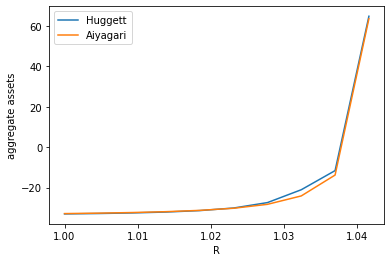

In [17]:
plt.plot(R_grid, A_vals, label='Huggett')
plt.plot(R_grid, A_vals_a, label='Aiyagari')
plt.xlabel('R')
plt.ylabel('aggregate assets')
plt.legend()

In [18]:
np.subtract(A_vals_a, A_vals)

array([ 0.1617575 ,  0.1799516 ,  0.18918648,  0.17655352,  0.10934884,
       -0.11665577, -0.86290593, -3.06034808, -2.19351162, -1.23185926])

In the figure above, we see that with both models aggregate assets increase with R. Intuitively, this is because a higher interest rate makes saving more appealing so individuals are incentivized to gather and keep higher assets to accrue the high interest. This relationship is weaker (i.e., the slope is smaller in magnitude) for values of R close to 1. This is because a low interest rate increases that chance that individuals are near the borrowing constraint, meaning that a marginal increase in R is going to pass through to increase consumption and keep aggregate assets low.

As the differences above show, at low levels of R the Aiyagari model predicts higher aggregate assets than the Huggett model. This relationship flips as some level of R. When determined endogenously, wages are decreasing in R. In the Aiyagari model, all of the interest rates plotted above correspond to a wage greater than 1 (the wage used in the Huggett model results above). A higher value of w means that income levels and variance both increase. 

# FINISH


In [19]:
# Function to get R implied by μ

def R_mu(μ, a_grid, s_grid, param=param_base):
    a_vals = np.append(a_grid, a_grid) # get vector showing a_val for e/ cell in μ
    K=0 #initialize agg capital supply
    for i in range(len(a_vals)):
        K += a_vals[i]*μ[i] # add capital value*share of people for each cell in μ
    N=0 #initialize agg labor supply
    y_vals =[] # get vector showing y_val for e/ cell in μ
    for i in range(len(s_grid)): #iterate over income state values
        y_vals = np.append(y_vals, np.repeat(s_grid[i], len(a_grid)))
    for i in range(len(y_vals)):
        N += y_vals[i]*μ[i]
    
    α=param['α']
    δ=param['δ']
    R_mu = α*(N/K)**(1-α) + 1-δ # get R implied by μ
    return R_mu, N, K

In [20]:
# Function to get w implied by μ
def w_mu(μ, a_grid, s_grid, param=param_base):
    R_m, N, K = R_mu(μ, a_grid, s_grid, param=param) # get R as fxn of μ
    α=param['α']
    δ=param['δ']
    w_mu = (1-α)*(α**(α/(1-α)))*(R_m - 1 + δ)**(-α/(1-α)) # get w as fxn of μ
    return w_mu

In [21]:
# function to find market-clearing R
def find_R(w='exog', param=param_base, eps=0.99, error=e_backward, imax=imax_backward):
    if w=='exog':
        R_star = opt.brentq(A_R, 1, 1/β)
    else: #with exogenous wages, find eq'm R iteratively
        amin= -1/.03
        R_guess = 1/β # guess R in middle of grid range
        e_R = error + 1
        i = 1
        while e_R > error and i < imax:
            R_old = R_guess
            r_guess = R_guess-1
            Va, a_policy, c_policy, param = backward(w=w, param={**param, 'r':r_guess, 'amin':amin})
            T = make_T(a_policy=a_policy, Π= Π, ma_grid=param['ma_grid'])
            T_R = T.T # transpose to get transition operator
            μ = get_mu(T_R)
            A = agg_A(μ, ma_grid=param['ma_grid'])

            w = w_R(R_guess, param=param) # get w implied by R_guess
            # Get R and w based on μ implied by R_guess
            R_m, N_m, K_m = R_mu(μ, a_grid=param['a_grid'], s_grid=param['s_grid'], param=param)
                # R_mu(μ(R_guess))
            w_m = w_mu(μ, a_grid=param['a_grid'], s_grid=param['s_grid'], param=param)
                # w_mu(w_R(R_guess))

            R_guess = (1-eps)*R_m + eps*R_old
            e_R = np.abs(R_m - R_old)
            
            i += 1
            if i % 500 == 0 and report == 'Y':
                print('current iteration:', i)
                print('current error:', e_R)
        if i == imax:
            print('Warning! -- used max backward iteration:', imax)
        
        R_star = R_old
    return R_star
        


In [25]:
R_eqm = find_R(w='exog')

In [22]:
R_eqm_a = find_R(w='endog')

In [23]:
# Plotting equilibrium invariant distribution

def plot_asset_dist(R_eqm, w='exog', label=''):
    r_eqm = R_eqm-1
    amin_eqm = -1/0.03
    Va_eqm, a_policy_eqm, c_policy_eqm, param_eqm = backward(w=w, param={**param_base, 'r': r_eqm, 'amin': amin_eqm}) 
    ma_grid_r_eqm = param_eqm['ma_grid']
    T_eqm = make_T(a_policy=a_policy_eqm, Π= Π, ma_grid=ma_grid_r_eqm)
    T_R_eqm = T_eqm.T # transpose to get transition operator
    μ_eqm = get_mu(T_R_eqm) # get stationary distribution
    print('aggregate assets: ', A_R(R_eqm, w=w))
    a_vals = np.append(ma_grid_r_eqm[0], ma_grid_r_eqm[0]) # (ns*na)x1 vector showing a values for μ_eqm
    a_dist = []
    for a in ma_grid_r_eqm[0]: # iterate over a bins
        a_dist.append(μ_eqm[a_vals == a].sum())
    plt.plot(ma_grid_r_eqm[0], a_dist, label=label)


aggregate assets:  8.68193667729862
aggregate assets:  -2.1397801011286486e-08


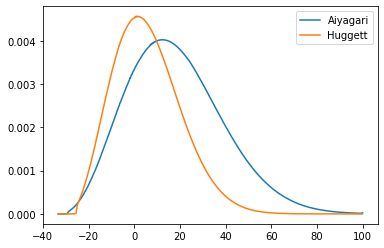

In [26]:
plot_asset_dist(R_eqm_a, w='endog', label='Aiyagari')
plot_asset_dist(R_eqm, label='Huggett')
plt.legend()